In [1]:
from adversarial_dataset import AdversarialDataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch
import matplotlib.pyplot as plt
from torchvision import models
import numpy as np
from tqdm.notebook import tqdm
import pandas as pd

In [2]:
def show_image(tensor):
    permuted = torch.permute(tensor.cpu(), (1, 2, 0))
    plt.imshow(permuted)

In [3]:
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

model = models.inception_v3(weights=models.Inception_V3_Weights.DEFAULT)
model.eval()
dataset = AdversarialDataset(annotation_file="images.csv",
                             categories_file="categories.csv",
                             img_dir="images",
                             noise_dir="adversarial_noise_untargeted",
                             img_transform=img_transform)

dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [4]:
dataset[0][0].shape

torch.Size([3, 299, 299])

In [5]:
def find_kp_point(image, model):
    n = image.shape[1]
    output = model(image[None])
    _, c_original = torch.max(output, dim=1)

    for k in reversed(range(1, n)):
        temp = torch.zeros(image.shape)[None]
        temp[:, :, :k, :] = image[None, :, :k, :]
        temp_output = model(temp)
        _, c = torch.max(temp_output, dim=1)

        if c != c_original:
            probabilities = torch.nn.functional.softmax(temp_output, dim=1)
            return k, probabilities[0, c].item(), c.item()
        
    print("Oops")
    probabilities = torch.nn.functional.softmax(output, dim=1)
    return 1, probabilities[0, c_original].item(), c_original.item()

In [51]:
kp_set = np.zeros((2*len(dataset), 4))
subset_length = len(dataset)

for i in tqdm(range(2*subset_length)):
    row = dataset[i%subset_length]

    img = row[0]
    noise = row[1]

    is_adv = i - subset_length >= 0
    if is_adv:
        img = img+noise

    k, p, c = find_kp_point(img, model)
    print(f"Point: ({k}, {p}). Class: {c}. Adv: {is_adv}")

    kp_set[i] = [k, p, c, is_adv]

  0%|          | 0/2000 [00:00<?, ?it/s]

Point: (96, 0.13093018531799316). Class: 14. Adv: False
Point: (228, 0.3989690840244293). Class: 738. Adv: False
Point: (143, 0.2875746488571167). Class: 159. Adv: False
Point: (114, 0.05861850455403328). Class: 846. Adv: False
Point: (260, 0.28074130415916443). Class: 969. Adv: False
Point: (187, 0.12066057324409485). Class: 957. Adv: False
Point: (95, 0.23094096779823303). Class: 522. Adv: False
Point: (140, 0.6320220232009888). Class: 23. Adv: False
Point: (238, 0.41275662183761597). Class: 656. Adv: False
Point: (209, 0.3294055163860321). Class: 656. Adv: False
Point: (275, 0.4434053599834442). Class: 454. Adv: False
Point: (144, 0.12499088048934937). Class: 675. Adv: False
Point: (64, 0.12247037142515182). Class: 549. Adv: False
Point: (212, 0.21887341141700745). Class: 611. Adv: False
Point: (132, 0.08041761070489883). Class: 674. Adv: False
Point: (91, 0.06981342285871506). Class: 579. Adv: False
Point: (291, 0.37416866421699524). Class: 630. Adv: False
Point: (127, 0.3480781316

In [57]:
df = pd.DataFrame(kp_set, columns=["x", "y", "class", "is_adversarial"])

In [59]:
df.to_csv("kppoints.csv")

In [7]:
df = pd.read_csv("kppoints.csv")

In [20]:
df = df.drop(['Unnamed: 0'], axis=1)
df.head()

,x,y,class,is_adversarial
0,96.0,0.130930,14.0,0.0
1,228.0,0.398969,738.0,0.0
2,143.0,0.287575,159.0,0.0
3,114.0,0.058619,846.0,0.0
4,260.0,0.280741,969.0,0.0


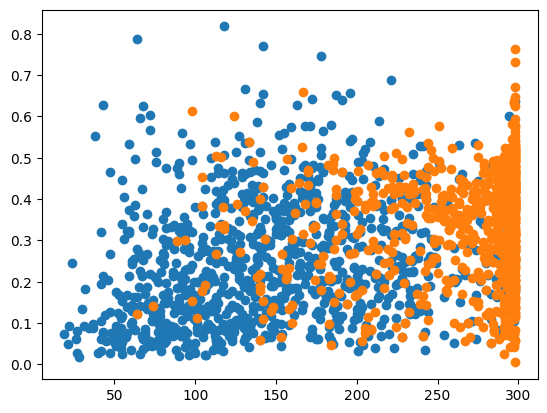

In [16]:
plt.scatter(df["x"][df["is_adversarial"] == 0], df["y"][df["is_adversarial"] == 0])
plt.scatter(df["x"][df["is_adversarial"] == 1], df["y"][df["is_adversarial"] == 1])

In [113]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.inspection import DecisionBoundaryDisplay

x_train, x_test, y_train, y_test = train_test_split(df[["x", "y", "class"]],
                                                    df["is_adversarial"],
                                                    stratify=df["is_adversarial"],
                                                    test_size=.2,
                                                    shuffle=True)

clf = LogisticRegression(random_state=0).fit(x_train[["x", "y"]], y_train)

/var/folders/7f/grjjgdz13lvfbfk5d3d3s06h0000gp/T/ipykernel_29147/820216053.py:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  disp.ax_.scatter(x_train["x"][y_train == 0], x_train["y"][y_train == 0], cmap="bwr", edgecolor="k", label="Benign")
/var/folders/7f/grjjgdz13lvfbfk5d3d3s06h0000gp/T/ipykernel_29147/820216053.py:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  disp.ax_.scatter(x_train["x"][y_train == 1], x_train["y"][y_train == 1], cmap="bwr", edgecolor="k", label="Adversarial")


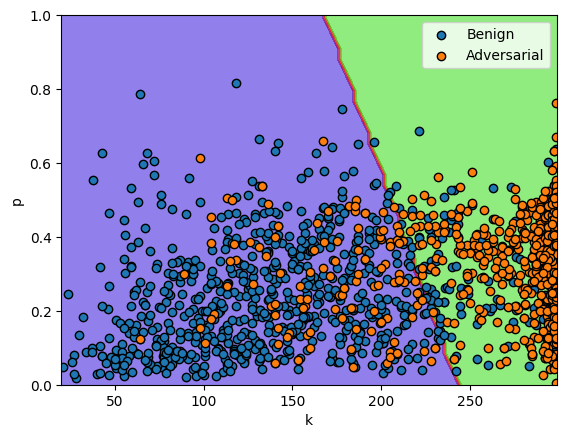

In [115]:
disp = DecisionBoundaryDisplay.from_estimator(clf, x_train[["x", "y"]], response_method="predict", xlabel="k", ylabel="p", alpha=.5)

disp.ax_.scatter(x_train["x"][y_train == 0], x_train["y"][y_train == 0], cmap="bwr", edgecolor="k", label="Benign")
disp.ax_.scatter(x_train["x"][y_train == 1], x_train["y"][y_train == 1], cmap="bwr", edgecolor="k", label="Adversarial")
# plt.set_cmap("brg")
# disp.ax_.scatter(x_train.iloc[:, 0], x_train.iloc[:, 1], c=y_train, edgecolor="k")
plt.ylim(0, 1)
plt.legend()

In [67]:
preds = clf.predict(x_test)

In [111]:
type(preds)

numpy.ndarray

In [133]:
preds = clf.predict(x_test[["x", "y"]])

final_predictions = []
real_predictions = []
for i in range(len(x_test)):
    org_idx = x_test.iloc[i].name
    image, noise, label, _, _ = dataset[org_idx % 1000]

    real_predictions.append(label)

    if preds[i]:
        final_predictions.append(x_test.iloc[i]["class"])
    else:
        if org_idx >= 1000:
            image = image + noise
        temp_output = model(image[None])
        _, c = torch.max(temp_output, dim=1)
        final_predictions.append(c)


In [134]:
corr = 0

for i in range(len(final_predictions)):
    eq = final_predictions[i] == real_predictions[i]

    if eq: corr+=1

In [135]:
corr

331

In [128]:
len(final_predictions)

200